### Linear Model Tree

### Importing the relevant libraries

In [114]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pytz

import plotly.express as px

mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
sns.set()
sns.set_style('whitegrid')

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

### Features of the data 

https://climate.weather.gc.ca/glossary_e.html#s <br>

$\textit{timestamp: }$ The date along with the time of the day the data was collected  <br>
$\textit{unixtime: }$ A system for describing a point in time <br>
$\textit{pressure_station: }$ The true pressure of the location recorded at the station in kilopascals (kPa) <br>
$\textit{pressure_sea: }$ The pressure at sea level in kilopascals (kPa) <br>
$\textit{wind_dir: }$ The direction of the wind <br>
$\textit{wind_dir_10: }$ Represented in 10s of degrees <br>
$\textit{wind_speed: }$ Speed of the motion of air in kilometres per hour (km/h) <br>
$\textit{wind_gust: }$ Sudden burst in wind speed in kilometres per hour (km/h) usually lasts for 20 seconds or under <br>
$\textit{relative_humidity: }$ Describes the amount of water vapour held in the air <br>
$\textit{dew_point: }$ The temperature in Celsius to which the air must be cooled before dew or frost begins to form  <br>
$\textit{temperature: }$ The current temperature of the air recorded at the station in Celsius <br>
$\textit{windchill: }$ Wind chill is an index to indicate how cold the weather feels to the average person <br>
$\textit{humidex: }$ Humidex is an index to indicate how hot or humid the weather feels to the average person <br>
$\textit{visibility: }$ Visibility in kilometres (km) is the distance at which objects of suitable size can be seen <br>
$\textit{health_index: }$ Scale designed to help you understand what the air quality around you means to your health <br>
$\textit{cloud_cover_4: }$ Measures the cloud cover <br>
$\textit{cloud_cover_8: }$ Measures the cloud cover <br>
$\textit{cloud_cover_10: }$ Measures the cloud cover <br>
$\textit{solar_radiation: }$ Solar radiation is the measurement of radiant energy from the sun <br>
$\textit{max_air_temp_pst1hr: }$ Maximum air temperature in the past one hour <br>
$\textit{min_air_temp_pst1hr: }$ Minimum air temperature in the past one hour <br>
$\textit{demand: }$ The electrical demand on hourly basis for the city of Toronto (MWhr) <br>

In [2]:
data = pd.read_csv('Data/Toronto_data.csv')
display(data.head())

timestamp    unixtime  pressure_station  pressure_sea wind_dir  \
0  2017-01-01 00  1483246800             98.67        100.79        W   
1  2017-01-01 01  1483250400             98.83        100.95        W   
2  2017-01-01 02  1483254000             98.95        101.08        W   
3  2017-01-01 03  1483257600             99.14        101.27        W   
4  2017-01-01 04  1483261200             99.28        101.41        W   

   wind_dir_10s  wind_speed  wind_gust  relative_humidity  dew_point  ...  \
0          26.0        35.0       45.0               69.0       -4.5  ...   
1          26.0        35.0        NaN               70.0       -4.5  ...   
2          26.0        32.0       43.0               67.0       -5.4  ...   
3          26.0        28.0        NaN               69.0       -5.1  ...   
4          26.0        27.0        NaN               69.0       -5.1  ...   

   humidex  visibility  health_index  cloud_cover_4  cloud_cover_8  \
0      NaN     24100.0           NaN            NaN            7.0   
1      NaN     24100.0           NaN            NaN            7.0   
2      NaN     24100.0           2.3            NaN            7.0   
3      NaN     24100.0           2.3            NaN            7.0   
4      NaN     24100.0           2.2            NaN            7.0   

   cloud_cover_10  solar_radiation  max_air_temp_pst1hr  min_air_temp_pst1hr  \
0             NaN              NaN                  0.9                  0.3   
1             NaN              NaN                  0.6                  0.2   
2             NaN              NaN                  0.3                 -0.1   
3             NaN              NaN                  0.0                 -0.2   
4             NaN              NaN                 -0.1                 -0.3   

   demand  
0    5665  
1    5665  
2    5665  
3    5665  
4    5665  

[5 rows x 22 columns]

I am particularly interested in predicting the electrical demand data. Temperature of the surrounding air, for obvious reasons, affects the electrical demand. We can drop the remaining columns and use the date_time_local as a datetime object to index the data frame.

In [3]:
data.drop(['unixtime','pressure_station','pressure_sea','wind_dir', 'wind_dir_10s', 'wind_gust','dew_point',
           'windchill','visibility', 'health_index', 'cloud_cover_4', 'cloud_cover_10', 'solar_radiation',
            'humidex','max_air_temp_pst1hr','min_air_temp_pst1hr','relative_humidity','wind_speed','cloud_cover_8']
          ,axis=1,inplace=True)

display(data.head())
display(data.shape)

timestamp  temperature  demand
0  2017-01-01 00          0.5    5665
1  2017-01-01 01          0.3    5665
2  2017-01-01 02          0.0    5665
3  2017-01-01 03         -0.1    5665
4  2017-01-01 04         -0.1    5665

(35496, 3)

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

data_noindex = data.copy()
data = data.set_index('timestamp')

display(data.head())

temperature  demand
timestamp                               
2017-01-01 00:00:00          0.5    5665
2017-01-01 01:00:00          0.3    5665
2017-01-01 02:00:00          0.0    5665
2017-01-01 03:00:00         -0.1    5665
2017-01-01 04:00:00         -0.1    5665

### Handling missing values

Let's check the number of missing data points in the temperature and demand data. Looks like IESO has been doing a good job maintaing their demand data. They seem to have adjusted for missing data already. And there are only 7 missing data points in the temperature data too. We will fix these shortly.

In [5]:
display(pd.DataFrame({'Missing Values':data.isna().sum(),'Percentage':data.isna().sum()*100/data.shape[0]}))

Missing Values  Percentage
temperature               7    0.019721
demand                    0    0.000000

Let us take a look at the missing values in the temperature and fix them. We can observe that the missing values are not continuous and therefore, we could use forward fill to fill in these missing data points.

In [6]:
display(data.query('temperature != temperature'))

temperature  demand
timestamp                               
2017-06-10 01:00:00          NaN    4509
2017-11-08 12:00:00          NaN    5972
2018-07-07 01:00:00          NaN    4614
2018-07-07 02:00:00          NaN    4389
2018-09-09 04:00:00          NaN    3705
2019-05-13 19:00:00          NaN    6040
2020-06-11 00:00:00          NaN    5528

In [7]:
data['temperature'] = data['temperature'].fillna(method='ffill')
display(pd.DataFrame({'Missing Values':data.isna().sum(),'Percentage':data.isna().sum()*100/data.shape[0]}))

Missing Values  Percentage
temperature               0         0.0
demand                    0         0.0

### Defining relevant Functions

We split the data set into various categories based on the domain knowledge of factors affecting the electrical demand

$\textit{Temperature: }$ Based on the above analysis we split it into "Hot" (>15 degrees) and "NotHot" (<15 degrees) <br>
$\textit{Time of the day: }$ Split into "AwakeHours" (7am to 10pm) and "SleepHours" (10pm to 7am) <br>
$\textit{Type of the day: }$ Split into "Weekend" and "Weekday" <br> 
$\textit{Pandemic effects: }$ We can look at the information available at https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Ontario#Lifting_of_restrictions_after_the_first_wave to look at different stages of lockdown.

In [139]:
def temp_(x):
    """
    Divides the dataset into two categories based on the temperature
    """
    if x > 15:
        return 'Hot'
    else:
        return 'NotHot'

def peak_(x):
    """
    Divides the dataset into two categories based on the hour of the day
    """
    if x >= 7 and x <= 22:
        return 'AwakeHours'
    else: 
        return 'SleepHours'
    
def weekday_(x):
    """
    Divides the dataset into two categories based on the day of the week
    """
    if x >= 5:
        return 'Weekend'
    else:
        return 'Weekday'
    
def pandemic_(x):
    """
    Divides the dataset into multiple categories based on the type of lockdown imposed
    """
    if x >= datetime.date(2020,12,21):
        return 'FullLockdown'
    elif x >= datetime.date(2020,10,10):
        return 'ModifiedStageTwo'
    elif x >= datetime.date(2020,8,12):
        return 'StageThree'
    elif x >= datetime.date(2020,6,24):
        return 'StageTwo'
    elif x >= datetime.date(2020,5,20):
        return 'StageOne'
    elif x >= datetime.date(2020,3,17):
        return 'FullLockdown'  
    else:
        return 'NormalDay'
    
def dayofweek_(x):
    """
    Divides the dataset into seven categories based on the day of the week
    """
    if x == 0:
        return 'Monday'
    elif x == 1:
        return 'Tuesday'
    elif x == 2:
        return 'Wednesday'
    elif x == 3:
        return 'Thursday'
    elif x == 4:
        return 'Friday'
    elif x == 5:
        return 'Saturday'
    elif x == 6:
        return 'Sunday'

est = pytz.timezone('US/Eastern')
def dst_index(x):
    """
    Divides the dataset into two categories based on whether or not daylight savings is in place
    """
    if est.localize(x).dst().seconds == 0:
        return "NoDST"
    else:
        return "DST"

Extracting several relevant features from the data

In [9]:
data['year'] = data.index.year
data['month'] = data.index.month
data['dayofweek'] = data.index.dayofweek
data['day'] = data.index.day
data['hour'] = data.index.hour
data['temp_index'] = data['temperature'].apply(temp_)
data['hour_index'] = data['hour'].apply(peak_)
data['week_index'] = data['dayofweek'].apply(weekday_)
data['day_index'] = data['dayofweek'].apply(dayofweek_)
data['day_status'] = [pandemic_(x.date()) for x in data.reset_index()['timestamp']]
data['dst_index'] = [dst_index(x) for x in data.reset_index()['timestamp']]
display(data.head())

temperature  demand  year  month  dayofweek  day  hour  \
timestamp                                                                     
2017-01-01 00:00:00          0.5    5665  2017      1          6    1     0   
2017-01-01 01:00:00          0.3    5665  2017      1          6    1     1   
2017-01-01 02:00:00          0.0    5665  2017      1          6    1     2   
2017-01-01 03:00:00         -0.1    5665  2017      1          6    1     3   
2017-01-01 04:00:00         -0.1    5665  2017      1          6    1     4   

                    temp_index  hour_index week_index day_index day_status  \
timestamp                                                                    
2017-01-01 00:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 01:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 02:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 03:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 04:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   

                    dst_index  
timestamp                      
2017-01-01 00:00:00     NoDST  
2017-01-01 01:00:00     NoDST  
2017-01-01 02:00:00     NoDST  
2017-01-01 03:00:00     NoDST  
2017-01-01 04:00:00     NoDST

### Holidays

Incorporating some of the public holidays and treating them as weekend

In [10]:
for year in list(data['year'].unique()):
    try:
        data.loc[str(year) + '-1-1','week_index'] = 'Weekend'
        data.loc[str(year) + '-7-1','week_index'] = 'Weekend'
        data.loc[str(year) + '-12-25','week_index'] = 'Weekend'
        data.loc[str(year) + '-12-26','week_index'] = 'Weekend'
    except:
        continue

### Exploratory Analysis

The other notebook "Analysis_ElectricityDemand" has a detailed analysis of various factors and its effects. In this we just revisit some of them quickly and plot them. It is a fair assumption to make that the electricity demand is strongly dependent on the temperature. In the plot below, we can see the relation between temperature and demand for various cases.

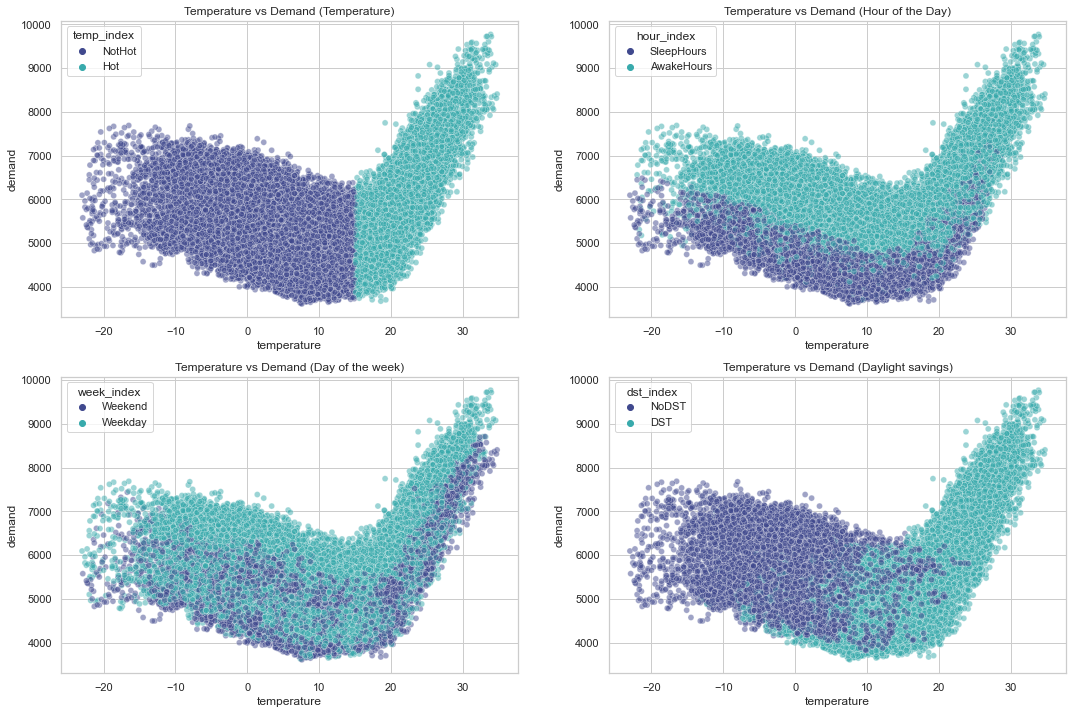

In [136]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.scatterplot(x='temperature',y='demand',hue='temp_index',data=data,ax=axes[0,0],palette="mako", alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand (Temperature)');
sns.scatterplot(x='temperature',y='demand',hue='hour_index',data=data,ax=axes[0,1],palette="mako", alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand (Hour of the Day)');
sns.scatterplot(x='temperature',y='demand',hue='week_index',data=data,ax=axes[1,0],palette="mako", alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand (Day of the week)');
sns.scatterplot(x='temperature',y='demand',hue='dst_index',data=data,ax=axes[1,1],palette="mako", alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand (Daylight savings)');

### Linear Model Tree

As discussed in "Analysis_ElectricityDemand", we can see a positive relationship in the Hot category and a negative relationship in the NotHot category. We can further divide it into two categories based on whether it is awake hours or sleep hours. This way we have four categories that have individual linear relationship.

In [141]:
def sections(x,y):
    """
    Divides the dataset into four sections as discussed above
    """
    if x == 'AwakeHours' and y == 'Hot':
        return 'Section1'
    elif x == 'AwakeHours' and y == 'NotHot':
        return 'Section2'
    elif x == 'SleepHours' and y == 'NotHot':
        return 'Section3'
    elif x == 'SleepHours' and y == 'Hot':
        return 'Section4'

In [14]:
data['sections'] = data.apply(lambda x: sections(x['hour_index'],x['temp_index']), axis=1)
display(data.head())

temperature  demand  year  month  dayofweek  day  hour  \
timestamp                                                                     
2017-01-01 00:00:00          0.5    5665  2017      1          6    1     0   
2017-01-01 01:00:00          0.3    5665  2017      1          6    1     1   
2017-01-01 02:00:00          0.0    5665  2017      1          6    1     2   
2017-01-01 03:00:00         -0.1    5665  2017      1          6    1     3   
2017-01-01 04:00:00         -0.1    5665  2017      1          6    1     4   

                    temp_index  hour_index week_index day_index day_status  \
timestamp                                                                    
2017-01-01 00:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 01:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 02:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 03:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 04:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   

                    dst_index  sections  
timestamp                                
2017-01-01 00:00:00     NoDST  Section3  
2017-01-01 01:00:00     NoDST  Section3  
2017-01-01 02:00:00     NoDST  Section3  
2017-01-01 03:00:00     NoDST  Section3  
2017-01-01 04:00:00     NoDST  Section3

In each of the sections, we can now spot a linear relationship and the corresponding pearson coefficients are shown below.

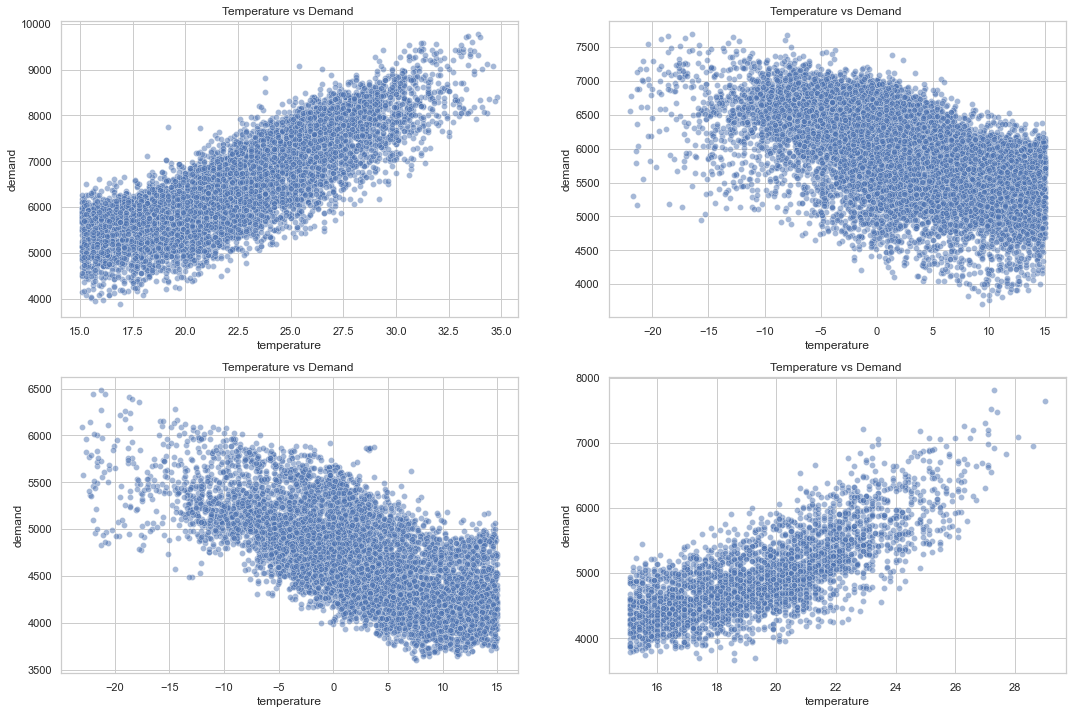

In [116]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section1"'),ax=axes[0,0], alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section2"'),ax=axes[0,1], alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section3"'),ax=axes[1,0], alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section4"'),ax=axes[1,1], alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand ');

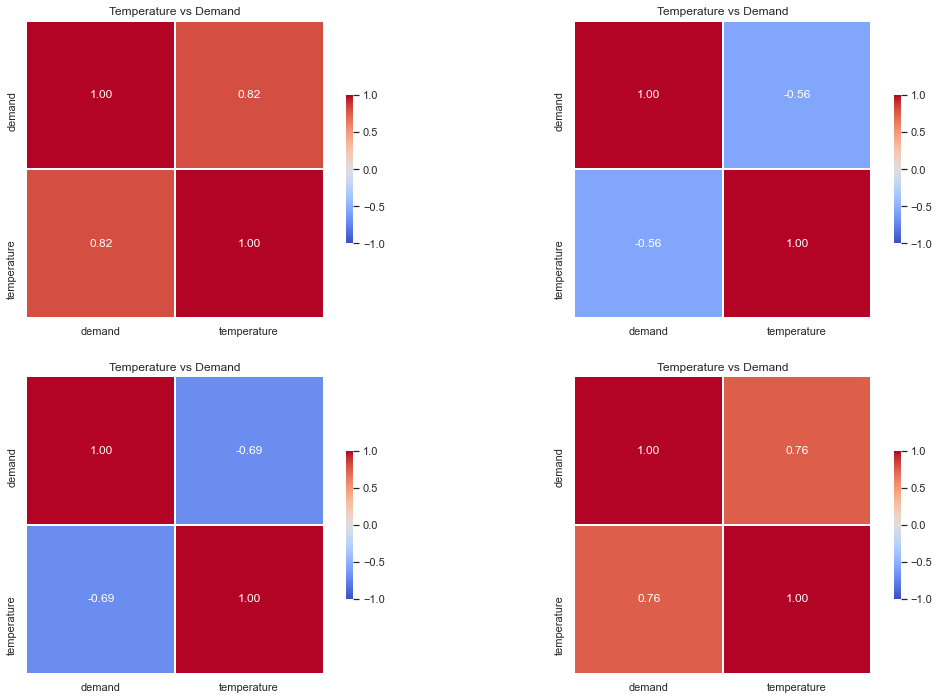

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.heatmap(data.query('sections == "Section1"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,0]);
axes[0,0].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections == "Section2"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,1]);
axes[0,1].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections == "Section3"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,0]);
axes[1,0].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections == "Section4"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,1]);
axes[1,1].set_title('Temperature vs Demand');

We can now split it further based on whether it is a weekend or weekday and we are going to end up with eight sections.

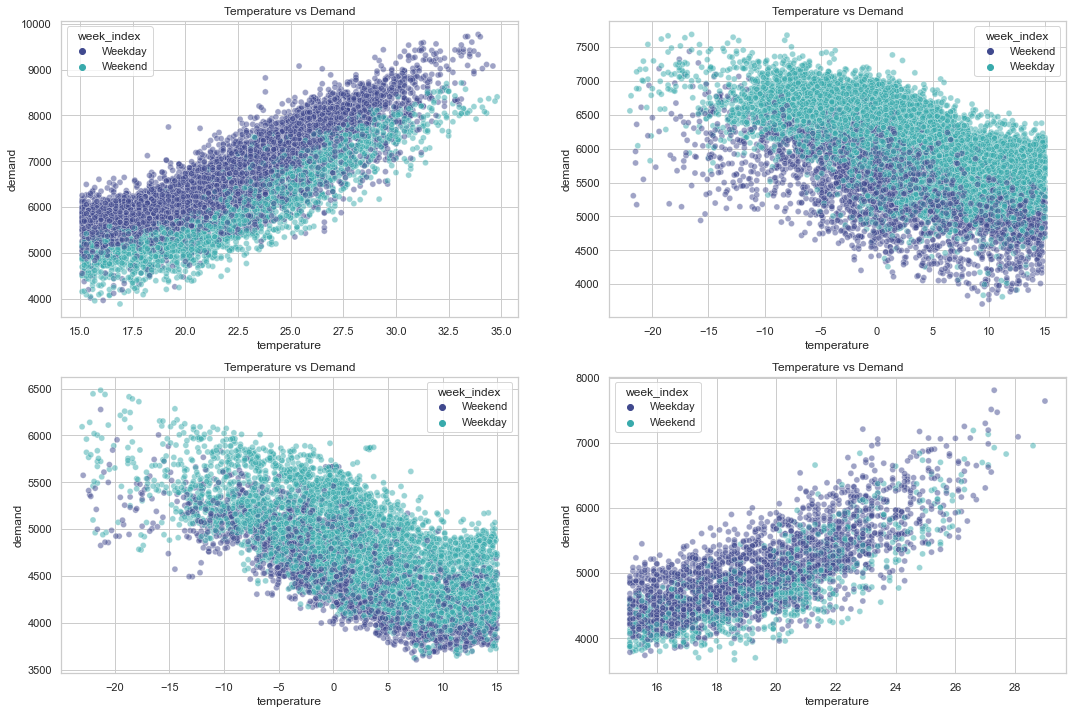

In [117]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section1"'),hue='week_index',ax=axes[0,0],palette="mako", alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section2"'),hue='week_index',ax=axes[0,1],palette="mako", alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section3"'),hue='week_index',ax=axes[1,0],palette="mako", alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section4"'),hue='week_index',ax=axes[1,1],palette="mako", alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand');

In [142]:
def sections_1(x,y):
    """
    Divides the dataset into eight sections as shown above
    """
    if x == 'Section1' and y == 'Weekend':
        return 'Section1'
    elif x == 'Section1' and y == 'Weekday':
        return 'Section2'
    elif x == 'Section2' and y == 'Weekend':
        return 'Section3'
    elif x == 'Section2' and y == 'Weekday':
        return 'Section4'
    elif x == 'Section3' and y == 'Weekend':
        return 'Section5'
    elif x == 'Section3' and y == 'Weekday':
        return 'Section6'
    elif x == 'Section4' and y == 'Weekend':
        return 'Section7'
    elif x == 'Section4' and y == 'Weekday':
        return 'Section8'

In [19]:
data['sections_1'] = data.apply(lambda x: sections_1(x['sections'],x['week_index']), axis=1)
display(data.head())

temperature  demand  year  month  dayofweek  day  hour  \
timestamp                                                                     
2017-01-01 00:00:00          0.5    5665  2017      1          6    1     0   
2017-01-01 01:00:00          0.3    5665  2017      1          6    1     1   
2017-01-01 02:00:00          0.0    5665  2017      1          6    1     2   
2017-01-01 03:00:00         -0.1    5665  2017      1          6    1     3   
2017-01-01 04:00:00         -0.1    5665  2017      1          6    1     4   

                    temp_index  hour_index week_index day_index day_status  \
timestamp                                                                    
2017-01-01 00:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 01:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 02:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 03:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 04:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   

                    dst_index  sections sections_1  
timestamp                                           
2017-01-01 00:00:00     NoDST  Section3   Section5  
2017-01-01 01:00:00     NoDST  Section3   Section5  
2017-01-01 02:00:00     NoDST  Section3   Section5  
2017-01-01 03:00:00     NoDST  Section3   Section5  
2017-01-01 04:00:00     NoDST  Section3   Section5

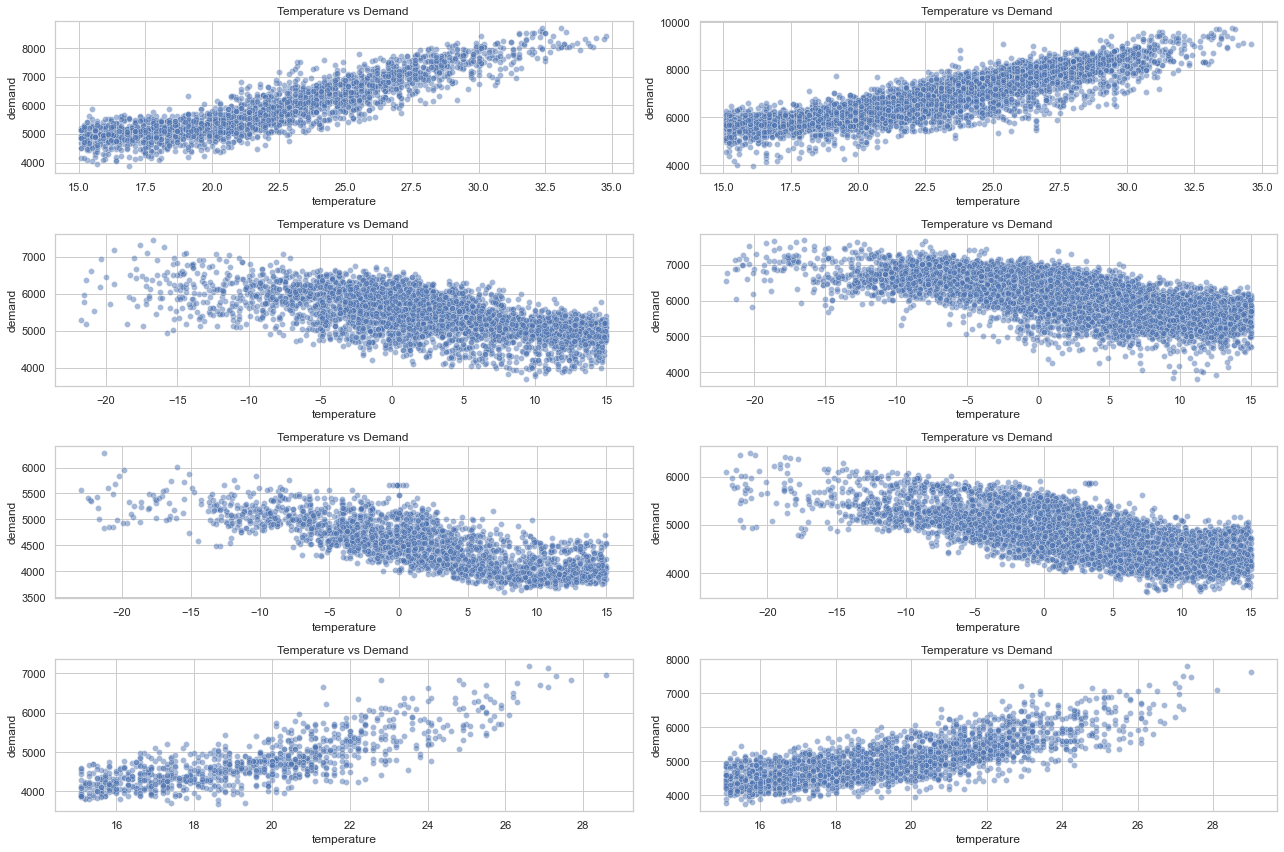

In [118]:
fig, axes = plt.subplots(nrows=4, ncols=2)

sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section1"'),ax=axes[0,0], alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section2"'),ax=axes[0,1], alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section3"'),ax=axes[1,0], alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section4"'),ax=axes[1,1], alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section5"'),ax=axes[2,0], alpha = 0.5);
axes[2,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section6"'),ax=axes[2,1], alpha = 0.5);
axes[2,1].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section7"'),ax=axes[3,0], alpha = 0.5);
axes[3,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section8"'),ax=axes[3,1], alpha = 0.5);
axes[3,1].set_title('Temperature vs Demand ');

fig.tight_layout();

We can now see a further stronger linear relationship in each of these sections and the pearson coefficients are shown below. 

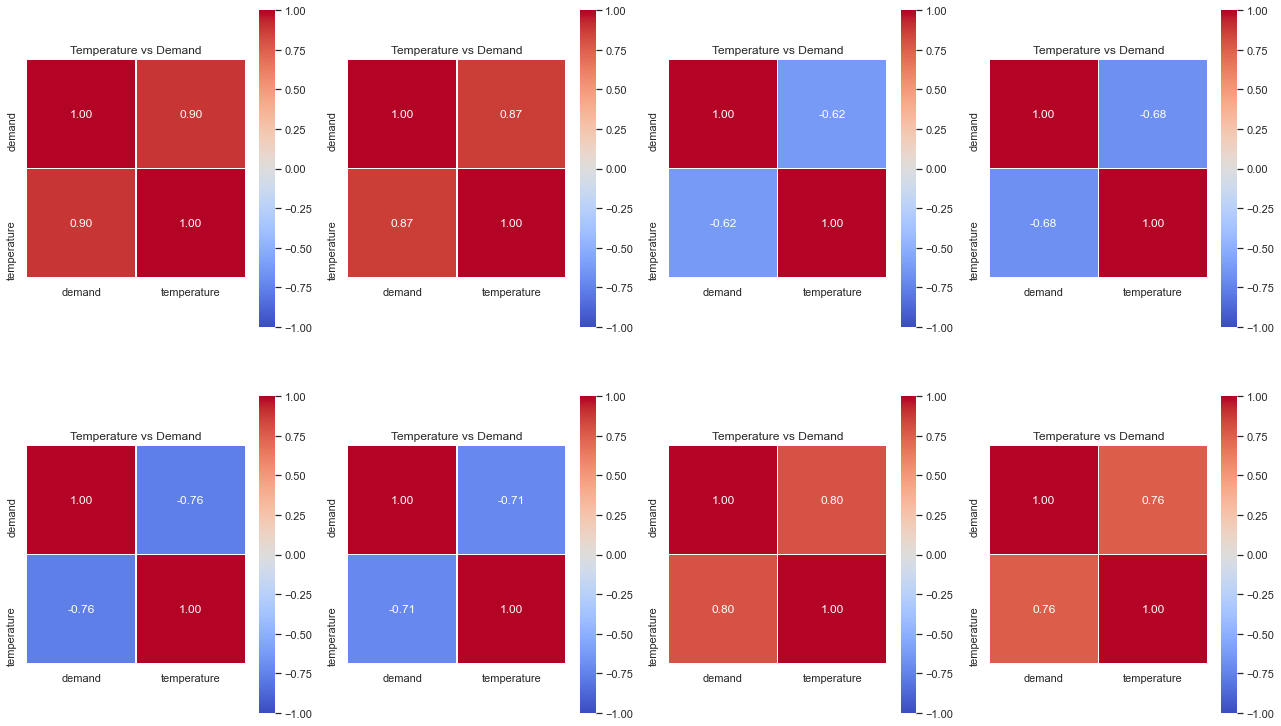

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=4)

sns.heatmap(data.query('sections_1 == "Section1"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,0]);
axes[0,0].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections_1 == "Section2"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,1]);
axes[0,1].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections_1 == "Section3"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,2]);
axes[0,2].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections_1 == "Section4"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,3]);
axes[0,3].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections_1 == "Section5"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,0]);
axes[1,0].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections_1 == "Section6"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,1]);
axes[1,1].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections_1 == "Section7"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,2]);
axes[1,2].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections_1 == "Section8"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,3]);
axes[1,3].set_title('Temperature vs Demand');

fig.tight_layout();

We can now split the dataset into a training set and a forecast set. We can use the data points from 2017 to 2020, to predict the first 18 days (=18$*$24 points). 

In [22]:
data_21 = data.loc['2021']
data_17_20 = data.loc['2017':'2020']

In [143]:
def predict(data,group_by,ridge_coef):
    """
    Given, a data point, the groups by which we split and the regression coefficients, this function returns a prediction
    """
    group = tuple(data[group_by])
    idx = groupby_list.index(group)
    (inter,slope) = ridge_coef[idx]
    return inter + slope*data['temperature']

def RMSE_error(data,forecast):
    """
    This function gives the RMSE for the forecats
    """
    return np.sqrt((1/data.shape[0])*np.sum(np.square(data-forecast)))

def baseline_model(data_1,data,i):
    """
    Defines a baseline model for 2021 forecast, based on 2020 datapoints
    """
    return data.loc['2020'].iloc[i]['demand']

### Baseline Model

In [25]:
demand_hat = []
for i in range(data_21.shape[0]):
    demand_hat.append(baseline_model(data_21.iloc[i],data,i))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat)}")

The RMSE is: 519.362035203875


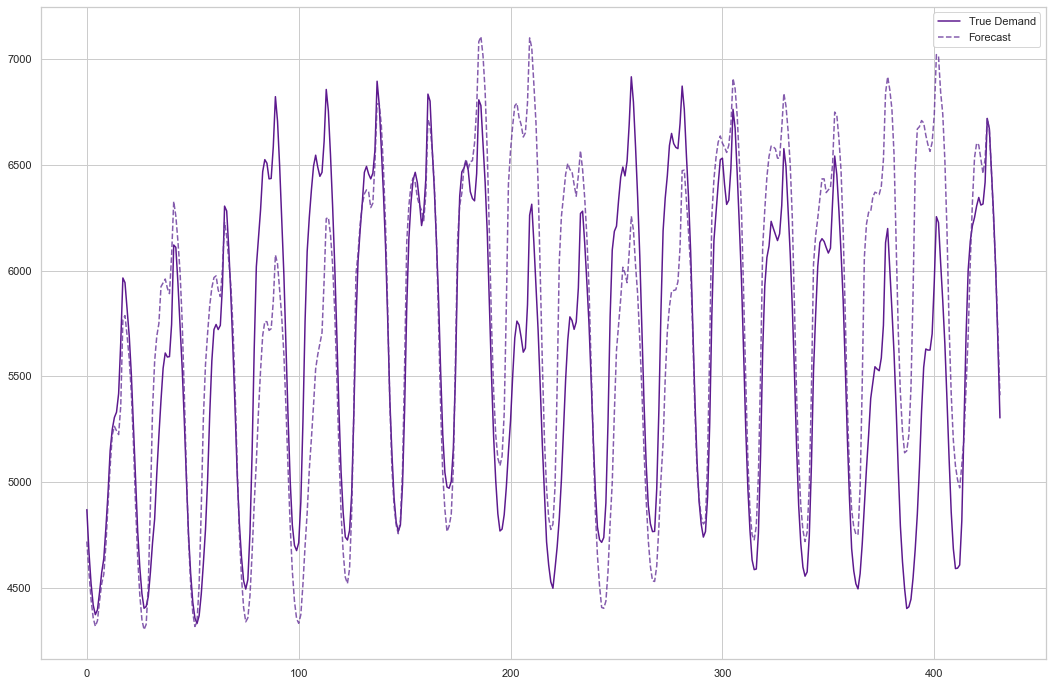

In [130]:
plt.plot(np.array(data_21['demand']),label='True Demand',color="indigo",alpha=0.9);
plt.plot(np.array(demand_hat),label='Forecast',color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.legend();

In [144]:
def Ridge_error(data):
    """
    Based on the provided data, this function returns the training error while performing ridge regression
    """
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    model = Ridge().fit(x,y)
    train_error = np.sqrt((1/y.shape[0])*np.sum(np.square(np.squeeze(model.predict(x)) - y.T)))
    return (float(train_error))

def Ridge_model(data):
    """
    Based on the provided data, this function returns the coefficients of the ridge regression
    """
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    model = Ridge().fit(x, y)
    return (float(model.intercept_),float(model.coef_))    

### Model with two categories 
#### ("AwakeHours" and  "SleepHours")
Here, we train a linear model with two categories for each of the eight sections

In [28]:
num = data_17_20['temp_index'].nunique()*data_17_20['hour_index'].nunique()*data_17_20['week_index'].nunique()

Train_error = np.zeros((num,1))

for i in range(1,num+1):
    train = data_17_20.groupby('sections_1').apply(Ridge_error)['Section'+str(i)]
    Train_error[i-1] = train

print(Train_error.mean())

389.6420854850157


The coefficients of regression in each of the category is shown below.

In [29]:
ridge_coef_1= data_17_20.groupby(['temp_index','hour_index','week_index']).apply(Ridge_model)
display(ridge_coef_1)

temp_index  hour_index  week_index
Hot         AwakeHours  Weekday        (2365.3584189384583, 195.8265810745037)
                        Weekend       (1464.6902359113883, 199.65016423002493)
            SleepHours  Weekday        (1662.603975389121, 173.55707882739256)
                        Weekend          (1214.835254235909, 181.721056952035)
NotHot      AwakeHours  Weekday        (6261.827964266722, -51.10636963437579)
                        Weekend       (5570.250503664445, -49.674227710491664)
            SleepHours  Weekday        (4876.917546039556, -47.33927329794538)
                        Weekend        (4588.637397627994, -46.31210782064537)
dtype: object

In [30]:
groupby_list = list(data.groupby(['temp_index','hour_index','week_index']).groups.keys())

In [31]:
demand_hat_1 = []
for i in range(data_21.shape[0]):
    demand_hat_1.append(predict(data_21.iloc[i],['temp_index','hour_index','week_index'],ridge_coef_1))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat_1)}")

The RMSE is: 344.0853434468074


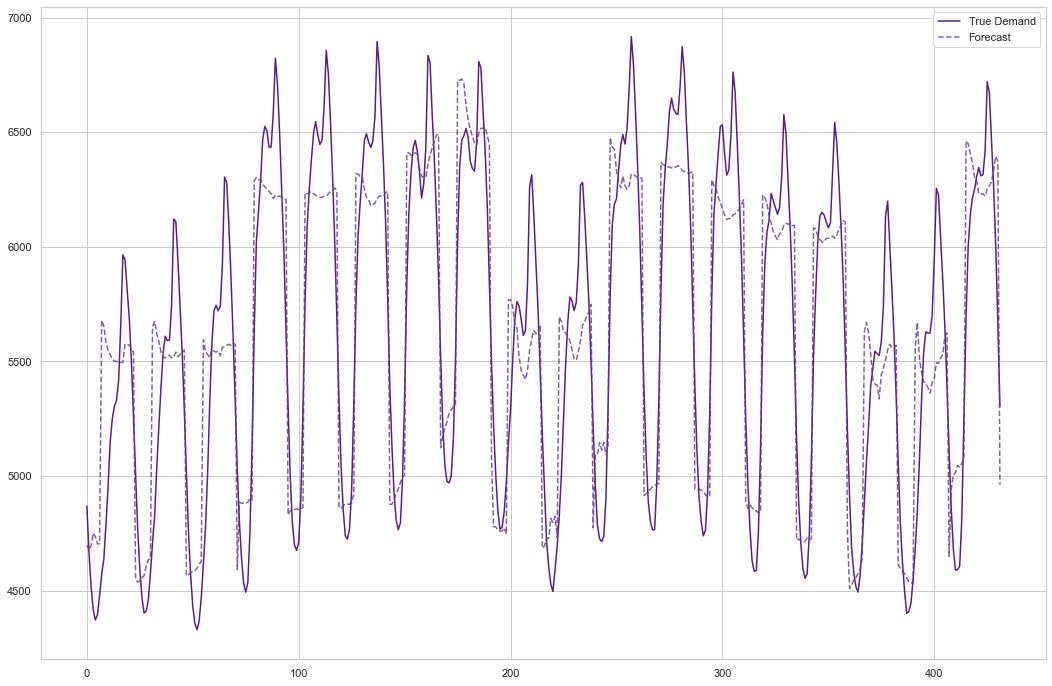

In [131]:
plt.plot(np.array(data_21['demand']),label='True Demand',color="indigo",alpha=0.9);
plt.plot(np.array(demand_hat_1),label='Forecast',color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.legend();

### Model with five categories 
#### ("EarlyMorning", "Morning", "Noon", "Evening" and "Night")
Here, we train a linear model with five categories. Therefore, we would have 2$*$2$*$5 = 20 sections. Of course we would;t be plotting all the 20 sections.

In [145]:
def peak_1(x):
    """
    Defining five categories based on the hour of the day
    """
    if x >= 0 and x <=5:
        return 'EarlyMorning'
    elif x > 5 and x <=8: 
        return 'Morning'
    elif x > 8 and x <=12:
        return 'Noon'
    elif x > 12 and x <=20:
        return 'Evening'
    elif x > 20 and x <=23:
        return 'Night'

In [34]:
data['hour_index_1'] = data['hour'].apply(peak_1)
display(data.head())

temperature  demand  year  month  dayofweek  day  hour  \
timestamp                                                                     
2017-01-01 00:00:00          0.5    5665  2017      1          6    1     0   
2017-01-01 01:00:00          0.3    5665  2017      1          6    1     1   
2017-01-01 02:00:00          0.0    5665  2017      1          6    1     2   
2017-01-01 03:00:00         -0.1    5665  2017      1          6    1     3   
2017-01-01 04:00:00         -0.1    5665  2017      1          6    1     4   

                    temp_index  hour_index week_index day_index day_status  \
timestamp                                                                    
2017-01-01 00:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 01:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 02:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 03:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   
2017-01-01 04:00:00     NotHot  SleepHours    Weekend    Sunday  NormalDay   

                    dst_index  sections sections_1  hour_index_1  
timestamp                                                         
2017-01-01 00:00:00     NoDST  Section3   Section5  EarlyMorning  
2017-01-01 01:00:00     NoDST  Section3   Section5  EarlyMorning  
2017-01-01 02:00:00     NoDST  Section3   Section5  EarlyMorning  
2017-01-01 03:00:00     NoDST  Section3   Section5  EarlyMorning  
2017-01-01 04:00:00     NoDST  Section3   Section5  EarlyMorning

A scatter plot of temperature vs demand showing all the five categories.

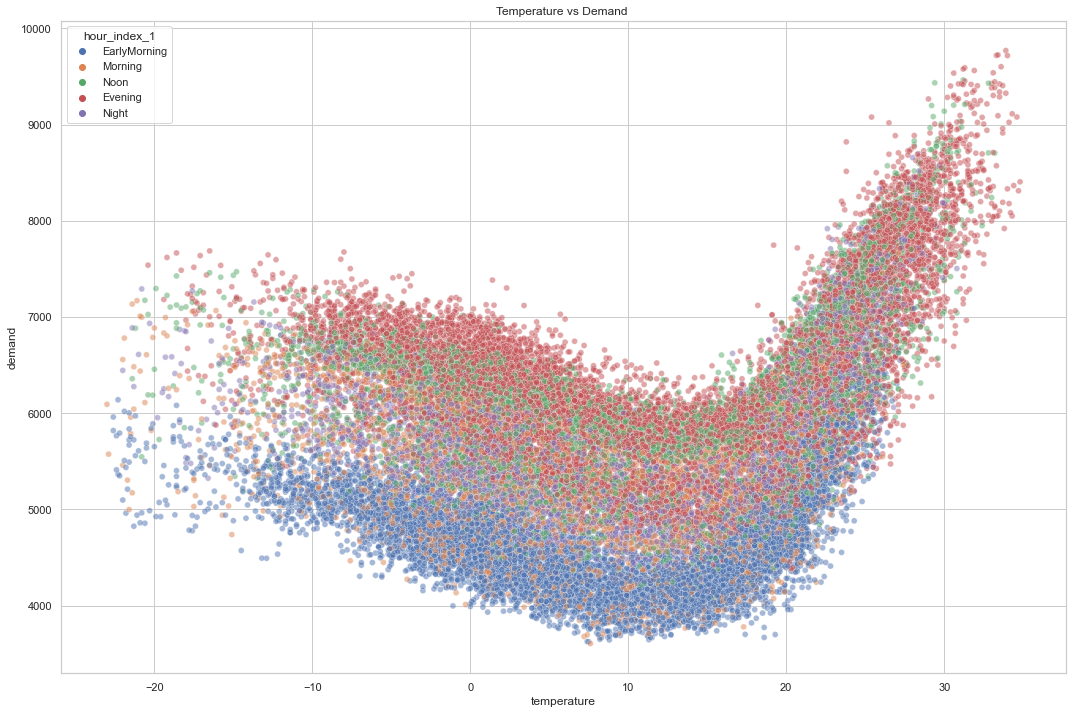

In [138]:
sns.scatterplot(x='temperature',y='demand',hue='hour_index_1',data=data, alpha = 0.5);
plt.title('Temperature vs Demand ');

This plot shows, how for each of the categorythe temperature dision makes it linear in each of them

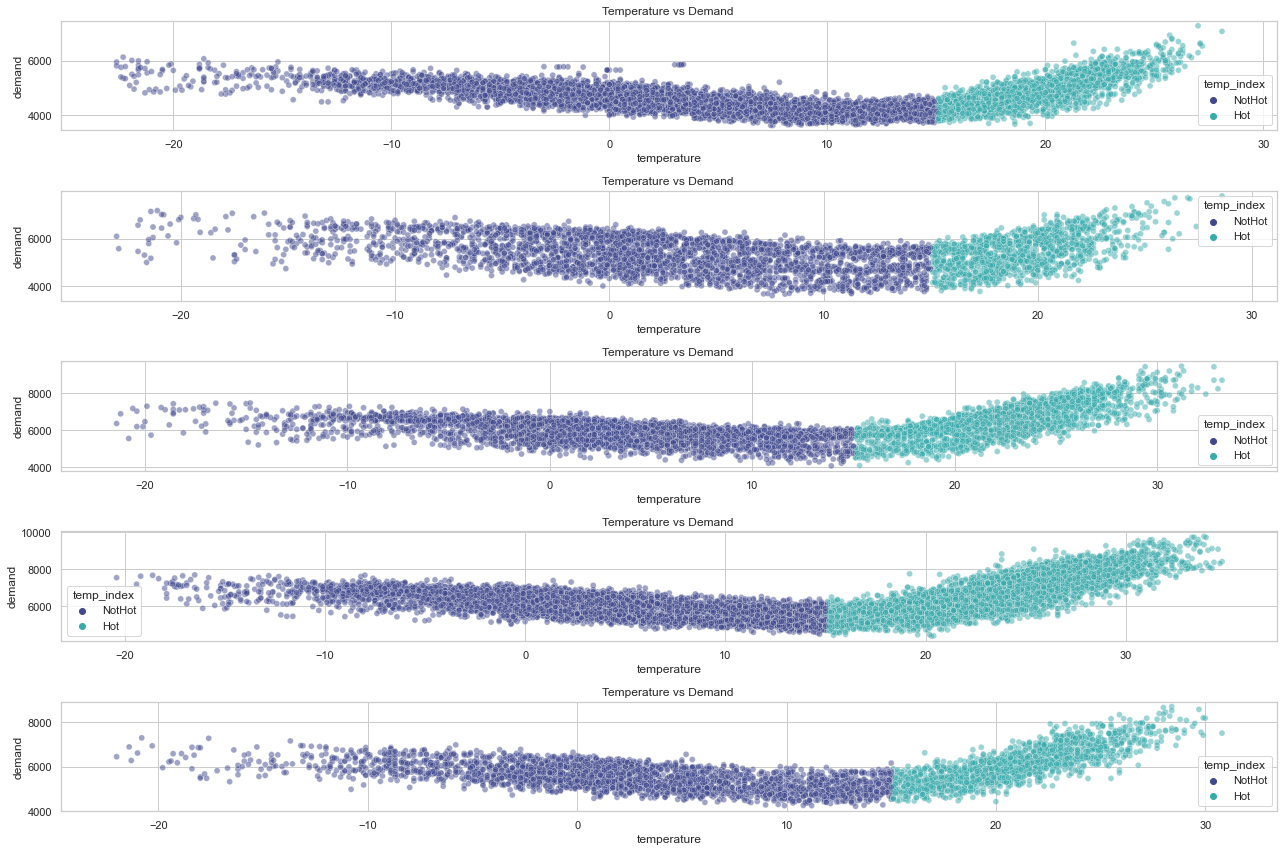

In [137]:
fig, axes = plt.subplots(nrows=5, ncols=1)

sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "EarlyMorning"'),hue='temp_index',ax=axes[0],palette="mako", alpha = 0.5);
axes[0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Morning"'),hue='temp_index',ax=axes[1],palette="mako", alpha = 0.5);
axes[1].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Noon"'),hue='temp_index',ax=axes[2],palette="mako", alpha = 0.5);
axes[2].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Evening"'),hue='temp_index',ax=axes[3],palette="mako", alpha = 0.5);
axes[3].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Night"'),hue='temp_index',ax=axes[4],palette="mako", alpha = 0.5);
axes[4].set_title('Temperature vs Demand ');

fig.tight_layout()

In [37]:
data_21 = data.loc['2021']
data_17_20 = data.loc['2017':'2020']

groupby_list = list(data.groupby(['temp_index','hour_index_1','week_index']).groups.keys())

The regression coefficient for each of the category is displayed below

In [38]:
ridge_coef_2 = data_17_20.groupby(['temp_index','hour_index_1','week_index']).apply(Ridge_model)
display(ridge_coef_2)

temp_index  hour_index_1  week_index
Hot         EarlyMorning  Weekday        (1703.6681786005888, 163.9411179772283)
                          Weekend       (1461.4924564503685, 165.31287451464084)
            Evening       Weekday       (2452.4053035324905, 193.03536038912847)
                          Weekend       (1684.8144357252095, 192.49185303956804)
            Morning       Weekday        (2523.3811596288037, 166.6698199567222)
                          Weekend       (1556.6899956927264, 166.38579761549943)
            Night         Weekday       (1736.8517367462518, 214.30643501354808)
                          Weekend       (1536.0987237377321, 201.13684909276014)
            Noon          Weekday        (2629.4539107967985, 186.4420994824526)
                          Weekend       (1561.4067766331082, 193.16079491732384)
NotHot      EarlyMorning  Weekday        (4735.676618587255, -46.53620517237581)
                          Weekend        (4522.834563900185, -46.0871718

In [39]:
num = data['temp_index'].nunique()*data['hour_index_1'].nunique()*data['week_index'].nunique()

Train_error = np.zeros((num,1))

for i in range(1,num+1):
    train = data_17_20.groupby(['temp_index','hour_index_1','week_index']).apply(Ridge_error)[i-1]
    Train_error[i-1] = train
    
print(Train_error.mean())

355.06555780518613


In [40]:
demand_hat_2 = []
for i in range(data_21.shape[0]):
    demand_hat_2.append(predict(data_21.iloc[i],['temp_index','hour_index_1','week_index'],ridge_coef_2))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat_2)}")

The RMSE is: 231.24476049317386


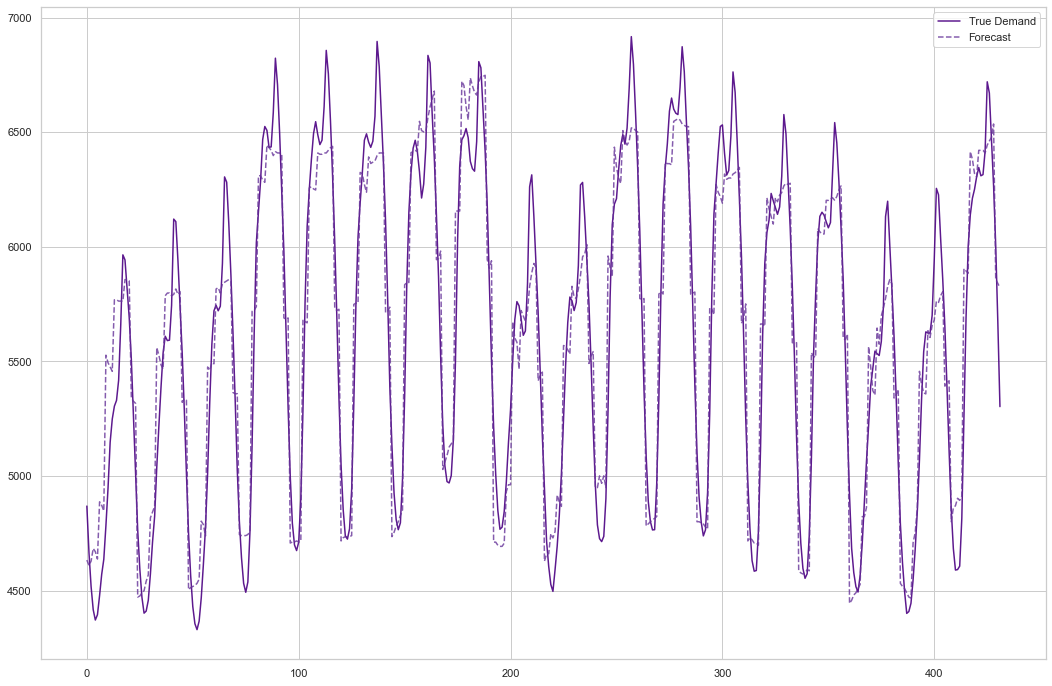

In [134]:
plt.plot(np.array(data_21['demand']),label='True Demand',color="indigo",alpha=0.9);
plt.plot(np.array(demand_hat_2),label='Forecast',color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.legend();

### Model with 24 categories 
#### One for each hour of the day
Here, we train a linear model with 24 categories. Therefore, we would have 2$*$2$*$24 = 96 sections. Therefore, we end up with 96 ridge regression models.

In [42]:
groupby_list = list(data.groupby(['temp_index','hour','week_index']).groups.keys())

In [43]:
ridge_coef_3 = data_17_20.groupby(['temp_index','hour','week_index']).apply(Ridge_model)
display(ridge_coef_3)

temp_index  hour  week_index
Hot         0     Weekday        (1619.6395983208636, 182.65656340884576)
                  Weekend        (1662.4883642631762, 173.25267613215252)
            1     Weekday          (1699.0140843152985, 166.949840415072)
                  Weekend        (1577.3154461601862, 165.89278673212073)
            2     Weekday        (1751.7572428253998, 156.14221333053186)
                                                  ...                    
NotHot      21    Weekend         (5650.532438727016, -48.60132825943837)
            22    Weekday        (5756.672371571148, -47.329384875887996)
                  Weekend         (5371.488095514949, -47.17301576672587)
            23    Weekday       (5325.5984153333775, -46.662917153952705)
                  Weekend           (5053.00232088674, -47.4842612470138)
Length: 96, dtype: object

In [44]:
num = data['temp_index'].nunique()*data['hour'].nunique()*data['week_index'].nunique()

Train_error = np.zeros((num,1))

for i in range(1,num+1):
    train = data_17_20.groupby(['temp_index','hour','week_index']).apply(Ridge_error)[i-1]
    Train_error[i-1] = train

print(Train_error.mean())

302.4882715688309


In [45]:
demand_hat_3 = []
for i in range(data_21.shape[0]):
    demand_hat_3.append(predict(data_21.iloc[i],['temp_index','hour','week_index'],ridge_coef_3))
print(f"The RMSE is: {RMSE_error(data_21['demand'],demand_hat_3)}")

The RMSE is: 140.0498289502413


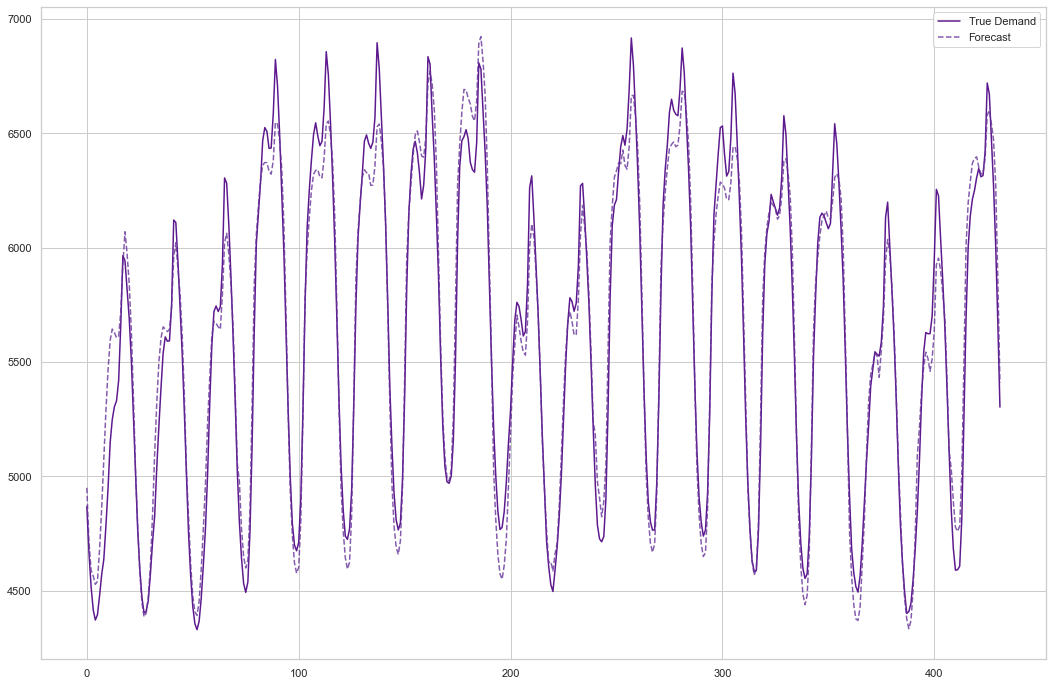

In [135]:
plt.plot(np.array(data_21['demand']),label='True Demand',color="indigo",alpha=0.9);
plt.plot(np.array(demand_hat_3),label='Forecast',color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.legend();